tested with tensorflow version 2.0

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from geopy import distance
import matplotlib.pyplot as plt
import random, math, datetime, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import glob
from tensorflow.keras import regularizers
from scipy import interpolate

In [2]:
input_file = "data/simulation/longdrive/"

params = {}
params["outputs"] = 6
params["splitIndex"] = 0.8

# begin linear interpolation

In [3]:
data = []
target = []

for i in range(0,10):
    ind = str(i) 
    f = input_file
    
    gps = pd.read_csv(f + "gps-" + ind + ".csv")
    gps.drop(columns=["gps_vN (m/s)","gps_vE (m/s)", "gps_vD (m/s)"], inplace=True)
    acc = pd.read_csv(f + "accel-" + ind + ".csv")
    gyro = pd.read_csv(f + "gyro-" + ind + ".csv")
    result = pd.concat([gps, acc, gyro], axis=1)
    result.columns = ["gps1", "gps2", "gps3", "acc1", "acc2", "acc3", "gyro1", "gyro2", "gyro3"]
    
    pos = pd.read_csv(input_file + "ref_pos.csv")
    ori = pd.read_csv(input_file + "ref_att_euler.csv")
    poses = pd.concat([ori, pos], axis=1)
    poses.columns = ["yaw", "pitch", "roll", "lat", "lon", "alt"]
    
    data.append(result.values)
    target.append(poses.values)
    
    
data = np.vstack(data)
target = np.vstack(target)   
print(data.shape, target.shape)

(965520, 9) (965520, 6)


In [4]:
params["input_features"] = data.shape[1]

params["scalerx"] = preprocessing.StandardScaler()
params["scalery"] = preprocessing.StandardScaler()
        
matrix = params["scalerx"].fit_transform(data)
poses = params["scalery"].fit_transform(target)

In [5]:
def generateSequences(data, matrix, seq_len):
    print(poses.shape)
    rows = poses.shape[0] - seq_len

    x = [matrix[index-seq_len:index, :] for index in range(seq_len, poses.shape[0])]
    x = np.array(x)
    y = poses[seq_len:, :]
    return x,y

In [6]:
params["seq_len"] = 500
x,y = generateSequences(data, matrix, params["seq_len"])
print(x.shape, y.shape)

(965520, 6)
(965020, 500, 9) (965020, 6)


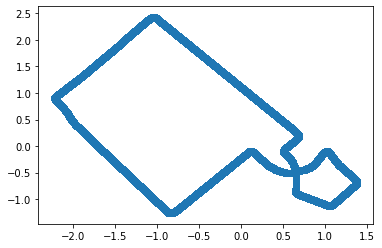

In [7]:
plt.scatter(y[:,4], y[:,3])
plt.show()

# train

In [8]:
split = int(x.shape[0] * params["splitIndex"])
train_x = x[:split]
train_y = y[:split]

test_x = x[split:]
test_y = y[split:]

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(772016, 500, 9) (772016, 6) (193004, 500, 9) (193004, 6)


In [10]:
def getDistance(preds, gt):
    return distance.distance(preds, gt).m

class Metrics(tf.keras.callbacks.Callback):
    
    def __init__(self, model, p, output=True):
        self.model = model
        self.p = p
        self.hist = []
        self.output = output

    def on_epoch_end(self, o, oo):
        inp = test_x
        targ = test_y
        pred = self.model.predict(inp)

        inv_pred = self.p["scalery"].inverse_transform(pred)
        inv_gt = self.p["scalery"].inverse_transform(targ)

        dists = []
        for i in range(inv_pred.shape[0]):
            d = getDistance(inv_pred[i,3:5], inv_gt[i, 3:5])
            dists.append(d)
        tmp = np.mean(dists)

        if self.output is True:
            
            if self.p["outputs"] == 6:
                pitch = mean_absolute_error(inv_pred[:,0], inv_gt[:, 0])
                roll = mean_absolute_error(inv_pred[:,1], inv_gt[:, 1])
                heading = mean_absolute_error(inv_pred[:,2], inv_gt[:, 2])
                self.hist.append( (tmp, pitch, roll, heading) )
                print(" -mae distance:", tmp, "pitch:", pitch, "roll:", roll, "yaw:", heading) 
            else:
                print(" -mea distance:", tmp)
                self.hist.append(tmp)

In [11]:
def plotti(train_data=False):
    inp = test_x
    targ = test_y
    
    if train_data is True:
        print("Using train data!")
        inp = train_x
        targ = train_y 
    
    pred = model.predict(inp)

    plt.scatter(pred[:,4], pred[:,3], label="pred")
    plt.scatter(targ[:,4], targ[:,3], label="gt")
    plt.title("test data")
    plt.legend()
    plt.show()

    inv_pred = params["scalery"].inverse_transform(pred)
    inv_gt = params["scalery"].inverse_transform(targ)

    dists = []
    for i in range(inv_pred.shape[0]):
        d = getDistance(inv_pred[i,3:5], inv_gt[i, 3:5])
        dists.append(d)
    print("mean distance:", np.mean(dists))

    plt.scatter(inv_pred[:,4], inv_pred[:,3], label="pred")
    plt.scatter(inv_gt[:,4], inv_gt[:,3], label="gt")
    plt.title("test data")
    plt.legend()
    plt.show()

### stateless

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (256, 256)                205056    
_________________________________________________________________
dense (Dense)                (256, 6)                  1542      
Total params: 206,598
Trainable params: 206,598
Non-trainable params: 0
_________________________________________________________________
Train on 772016 samples, validate on 193004 samples
Epoch 1/5
772016/772016 [==============================] - 296s 383us/sample - loss: 0.0472 - val_loss: 0.0099
Epoch 2/5
772016/772016 [==============================] - 294s 381us/sample - loss: 0.0083 - val_loss: 0.0060
Epoch 3/5
772016/772016 [==============================] - 296s 383us/sample - loss: 0.0098 - val_loss: 0.0514
Epoch 4/5
772016/772016 [==============================] - 292s 378us/sample - loss: 0.0076 - val_loss: 0.0043
Epoch 5/5
772016

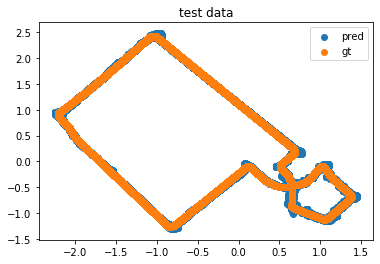

mean distance: 7.480602766104644


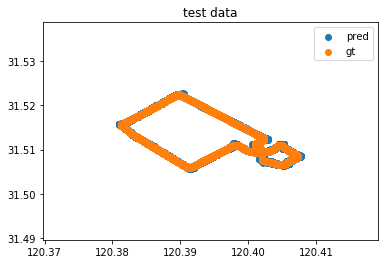

In [12]:
p = params.copy()
p["batch_size"] = 256

input_shape = (p["seq_len"], p["input_features"])  # (batch), timestep, input_dim
batch_input_shape = p["batch_size"],p["seq_len"],p["input_features"]

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(batch_input_shape=batch_input_shape),
    tf.keras.layers.GRU(256, return_sequences=False),
    tf.keras.layers.Dense( p["outputs"], activation = "linear")
])

model.compile(optimizer='adam', loss='mae')
model.summary()

cb = []
cb.append(Metrics(model, p))

history = model.fit(train_x, train_y, validation_data=(test_x,test_y), epochs=5, batch_size=p["batch_size"], callbacks=cb)
plotti()